# Bird Classification with Tensorflow on Amazon SageMaker - Directly in your notebook

1. [Introduction](#Introduction)
2. [Data Preparation](#Data-Preparation)
3. [Train the model](#Train-the-model)
4. [Test the model](#Test-the-model)
5. [Model Explainability](#Model-Explainability)

## Introduction

Image classification is an increasingly popular machine learning technique, in which a trained model predicts which of several classes is represented by a particular image. This technique is useful across a wide variety of use cases from manufacturing quality control to medical diagnosis. To create an image classification solution, we need to acquire and process an image dataset, and train a model from that dataset. The trained model is then capable of identifying features and predicting which class an image belongs to. Finally, we can make predictions using the trained model against previously unseen images.

This notebook is an end-to-end example showing how to build an image classifier using TensorFlow and Keras, simply using Amazon SageMaker Studio IDE directly. This is an easy transition from traditional machine learning development you may already be doing on your laptop or on an Amazon EC2 instance. Subsequent notebooks in this workshop will demonstrate how to take full advantage of SageMaker's training service, hosting service, and automatic model tuning. Note that for complex large scale machine learning models, training directly in a notebook can be cost prohibitive.

For each of the labs in this workshop, we use a publicly available set of bird images based on the [Caltech Birds (CUB 200 2011)](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset. We demonstrate transfer learning by leveraging pretrained ImageNet weights for a MobileNet V2 network architecture.

For a quick demonstration, pick a small handful of bird species (set `SAMPLE_ONLY = True` and choose a few classes / species). For a more complete model, you can train against all 200 bird species in the dataset. For anything more than a few classes, be sure to upgrade your Studio notebook instance type to one of SageMaker's GPU instance types (ml.p2, ml.p3, ml.g4dn).

This notebook was tested on a SageMaker Studio Instance with the `Tensorflow 2.3 Python 3.7` Image

## Data Preparation

The [Caltech Birds (CUB 200 2011)](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset contains 11,788 images across 200 bird species (the original technical report can be found [here](http://www.vision.caltech.edu/visipedia/papers/CUB_200_2011.pdf)).  Each species comes with around 60 images, with a typical size of about 350 pixels by 500 pixels.  Bounding boxes are provided, as are annotations of bird parts.  A recommended train/test split is given, but image size data is not.

![](./cub_200_2011_snapshot.png)

The dataset can be downloaded [here](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html).

### Download and unpack the dataset

Here we download the birds dataset from CalTech. The download and extraction can take about 10 min but you only need to run this once and keep the unpacked dataset in your notebook instance.

In [ ]:
DATA_LOCATION = "https://s3.amazonaws.com/ee-assets-prod-us-east-1/modules/05fa7598d4d44836a42fde79b26568b2/v2/CUB_200_2011.tgz"

In [ ]:
!wget  '{DATA_LOCATION}'
!tar xzf CUB_200_2011.tgz --no-same-owner

### Set some parameters for the rest of the notebook to use
Here we define a few parameters that help drive the rest of the notebook.  For example, `SAMPLE_ONLY` is defaulted to `True`. This will force the notebook to train on only a handful of species.  Setting `SAMPLE_ONLY` to false will make the notebook work with the entire dataset of 200 bird species.  This makes the training a more difficult challenge, and you will need to tune parameters and run more epochs.


In [1]:
# install data viz libraries
!pip install -Uqq matplotlib
!pip install -Uqq seaborn

In [2]:
import pandas as pd
import numpy as np
import random
from itertools import chain
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
import os
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed = 12345
random.seed(12345)

BASE_PATH = Path("CUB_200_2011/")
# To speed up training and experimenting, you can use a small handful of species.
# To see the full list of the classes available, look at the content of CLASSES_FILE.
SAMPLE_ONLY  = True
NUM_CLASSES = 10 # specify the number of species to sample

df_classes = pd.read_csv((BASE_PATH / "classes.txt"), sep=" ", header=None, names=["class_num", "class_id"])

if SAMPLE_ONLY:
    df_classes = df_classes.sample(n=NUM_CLASSES)
SELECTED_CLASSES = df_classes["class_id"].values.tolist() 
IMAGE_FILES = list(chain(*[(BASE_PATH / f"images/{specie}/").glob("*.jpg") for specie in SELECTED_CLASSES]))
    
label_encoder = LabelEncoder().fit(df_classes["class_id"])
    
df_classes["label"] = label_encoder.transform(df_classes["class_id"])

df_data = pd.DataFrame([img.as_posix() for img in IMAGE_FILES], columns=["file_name"])
df_data["class_id"] = df_data["file_name"].apply(lambda x: x.split("/")[-2])
df_data = df_data.merge(df_classes, on="class_id")

In [3]:
df_data.head()

,file_name,class_id,class_num,label
0,CUB_200_2011/images/095.Baltimore_Oriole/Balti...,095.Baltimore_Oriole,95,5
1,CUB_200_2011/images/095.Baltimore_Oriole/Balti...,095.Baltimore_Oriole,95,5
2,CUB_200_2011/images/095.Baltimore_Oriole/Balti...,095.Baltimore_Oriole,95,5
3,CUB_200_2011/images/095.Baltimore_Oriole/Balti...,095.Baltimore_Oriole,95,5
4,CUB_200_2011/images/095.Baltimore_Oriole/Balti...,095.Baltimore_Oriole,95,5


## Understand the dataset
Let's have a look at a few images of random species
The following code displays a grid of thumbnails for a random set of images

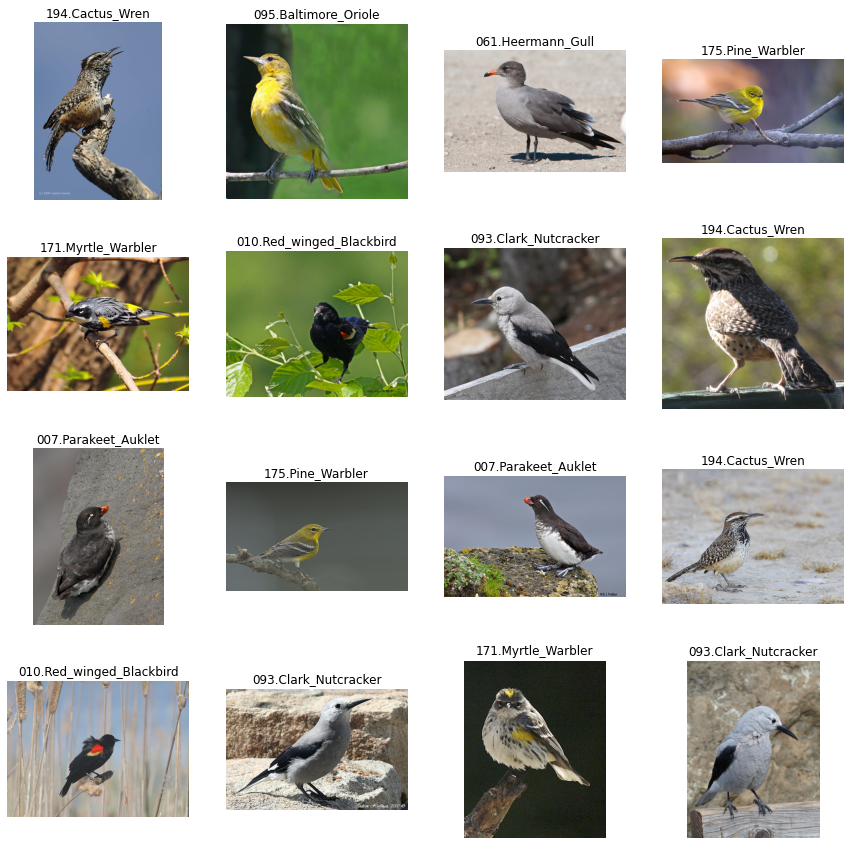

In [4]:
random_images = random.sample(IMAGE_FILES, 16)

plt.rcParams["figure.figsize"] = (15,15)
for n, image in enumerate(random_images, 1):
    title = image.as_posix().split("/")[-2]
    plt.subplot(4,4,n, title=title)
    plt.imshow(plt.imread(image))
    plt.axis("off")

### Create train/val/test dataframes from our dataset
Here we split our files into training, testing, and validation datasets

In [5]:
from sklearn.model_selection import train_test_split
train_size = 0.6
train_data, test_val_data= train_test_split(df_data, train_size=train_size, stratify=df_data["label"])

# split the testing and validation files into their respective sets
test_val_ratio = 0.6
test_data = test_val_data.sample(frac=test_val_ratio)
val_data = test_val_data[~test_val_data.index.isin(test_data.index)]

In [6]:
train_data.head()

,file_name,class_id,class_num,label
525,CUB_200_2011/images/132.White_crowned_Sparrow/...,132.White_crowned_Sparrow,132,6
204,CUB_200_2011/images/171.Myrtle_Warbler/Myrtle_...,171.Myrtle_Warbler,171,7
348,CUB_200_2011/images/061.Heermann_Gull/Heermann...,061.Heermann_Gull,61,3
17,CUB_200_2011/images/095.Baltimore_Oriole/Balti...,095.Baltimore_Oriole,95,5
453,CUB_200_2011/images/194.Cactus_Wren/Cactus_Wre...,194.Cactus_Wren,194,9


## Train the model 
In this section of the notebook, we train an image classification model to predict the bird species. In many cases, you are able to leverage a technique called [transfer learning](https://www.tensorflow.org/tutorials/images/transfer_learning), which uses pretrained models to dramatically simplify the process. Highly accurate classification models can be built using relatively small datasets and very few epochs, since you are starting with pretrained weights. In this notebook, we use pretrained models from [Tensorflow's model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md).

### Prepare image data generators from our dataframes
In this section, we use Tensorflow's [tf.data](https://www.tensorflow.org/guide/data) api to build a preprocessing pipeline for our training, testing, and validation images. Tensorflow training will use these pipelines to pull sets of images as it makes its way through each training epoch. We're also adding image augmentation to our training data to reduce overfit. Random adjustments are made to image brightness, rotation, width, and height, and some images will be flipped along the horizontal axis (for a bird facing left, provide an equivalent image with the bird facing to the right instead). There are several ways to perform Image data augmentation in TensorFlow, in the below example we'll be leverageing [Pre Processing Layers](https://www.tensorflow.org/guide/keras/preprocessing_layers). Tensorflow also provides general functions which can be used for image data augmentation found in the [tf.image](https://www.tensorflow.org/api_docs/python/tf/image) module.

In [7]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.data.experimental import AUTOTUNE
from functools import partial


NUM_EPOCHS = 10

def load_image(image_path, image_label):
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, (128, 128))
   
    return (image, image_label)

# This is a keras model that will be used for data augmentation
augmenter = tf.keras.Sequential([
            preprocessing.RandomFlip("horizontal_and_vertical"),
            preprocessing.RandomZoom(
                height_factor=(-0.05, -0.15),
                width_factor=(-0.05, -0.15)),
            preprocessing.RandomRotation(0.3)
            ])

def augment_image(image, label, augmenter):
    
    image = augmenter(image)

    return (image, label)


image_augmentation = partial(augment_image, augmenter=augmenter)

def make_ds(data, batch_size=32, shuffle=True, augment=True):

    image_paths = data["file_name"].values
    image_labels = data["label"].values
    

    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    
    if shuffle:
        ds = ds.shuffle(len(image_paths), seed=1234)
    
    ds = (ds.map(load_image, num_parallel_calls=AUTOTUNE)
        .cache()
        .batch(batch_size)
         )
    
    if augment:
        ds = ds.map(image_augmentation, num_parallel_calls=AUTOTUNE)
    
    ds = ds.prefetch(AUTOTUNE)
          
    return ds

train_ds = make_ds(train_data, batch_size=32, shuffle=True, augment=True)
test_ds = make_ds(test_data, batch_size=test_data.shape[0], shuffle=False, augment=False)

[2021-09-28 19:58:45.319 tensorflow-2-3-gpu--ml-g4dn-xlarge-857ba94c8ff520cf618cce107153:6256 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-09-28 19:58:45.344 tensorflow-2-3-gpu--ml-g4dn-xlarge-857ba94c8ff520cf618cce107153:6256 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [8]:
def build_model(base_model, num_classes):
    
    x = Flatten()(base_model.output)
    x = Dense(units=256, activation="relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=num_classes, activation="softmax")(x)
    
    return tf.keras.Model(inputs=base_model.input, outputs=x)

In [9]:
tf.keras.backend.clear_session() # clear current session when reruning the command
base_model = MobileNetV2(weights='imagenet',
                   include_top=False,
                   input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

model = build_model(base_model, df_data["label"].unique().shape[0])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy']
             )

tb_log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_log_dir, 
                                                      write_images=True,
                                                      histogram_freq=1,
                                                      update_freq="epoch")

In [10]:
history = model.fit(x=train_ds, validation_data=test_ds, epochs=NUM_EPOCHS, callbacks=[tensorboard_callback])

Epoch 1/10
 1/12 [=>............................] - ETA: 0s - loss: 3.9420 - accuracy: 0.0625WARNING:tensorflow:From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


 2/12 [====>.........................] - ETA: 2s - loss: 3.0348 - accuracy: 0.2031WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1373s vs `on_train_batch_end` time: 0.3191s). Check your callbacks.


12/12 [==============================] - 4s 301ms/step - loss: 1.9712 - accuracy: 0.4254 - val_loss: 1.7989 - val_accuracy: 0.7273
Epoch 2/10
12/12 [==============================] - 2s 141ms/step - loss: 0.7772 - accuracy: 0.7408 - val_loss: 1.1117 - val_accuracy: 0.7413
Epoch 3/10
12/12 [==============================] - 2s 144ms/step - loss: 0.4887 - accuracy: 0.8394 - val_loss: 0.7583 - val_accuracy: 0.7902
Epoch 4/10
12/12 [==============================] - 2s 145ms/step - loss: 0.4699 - accuracy: 0.8394 - val_loss: 0.5847 - val_accuracy: 0.8252
Epoch 5/10
12/12 [==============================] - 2s 146ms/step - loss: 0.3736 - accuracy: 0.8620 - val_loss: 0.5261 - val_accuracy: 0.8322
Epoch 6/10
12/12 [==============================] - 2s 148ms/step - loss: 0.2979 - accuracy: 0.9014 - val_loss: 0.4906 - val_accuracy: 0.8392
Epoch 7/10
12/12 [==============================] - 2s 139ms/step - loss: 0.2776 - accuracy: 0.9014 - val_loss: 0.4521 - val_accuracy: 0.8531
Epoch 8/10
12/12 

# Test the model

### Plot accuracy and loss across epochs
We can plot the accuracy and loss curves across epochs to analyze how the model improved through each iteration through the data.
With a fairly small dataset and a large model (MobileNetV2 has over 3M parameters) you'd likely see an overfit as the training accuracy quickly converges 100% while showing no improvement in validation accuarcy 

[Text(1, 0, '1'),
 Text(3, 0, '3'),
 Text(5, 0, '5'),
 Text(7, 0, '7'),
 Text(9, 0, '9')]

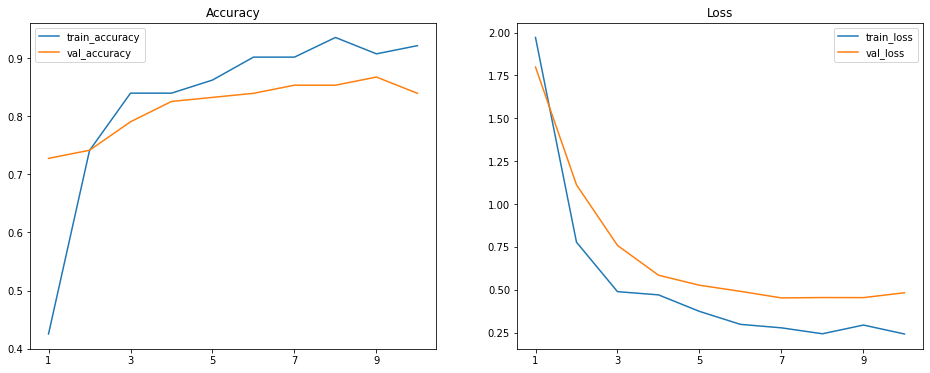

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(16,6))
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=history.history["accuracy"], ax=axs[0])
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=history.history["val_accuracy"], ax=axs[0] )

sns.lineplot(x=range(1,NUM_EPOCHS+1), y=history.history["loss"], ax=axs[1])
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=history.history["val_loss"], ax=axs[1] )

axs[0].legend(["train_accuracy", "val_accuracy"])
axs[0].set_title("Accuracy")
axs[0].set_xticks(range(1,NUM_EPOCHS+1,2))
axs[0].set_xticklabels(range(1,NUM_EPOCHS+1, 2))
axs[1].legend(["train_loss", "val_loss"])
axs[1].set_title("Loss")
axs[1].set_xticks(range(1,NUM_EPOCHS+1,2))
axs[1].set_xticklabels(range(1,NUM_EPOCHS+1, 2))

### Analyze the model with TensorBoard
We can also use [TensorBoard](https://www.tensorflow.org/tensorboard), a visualization toolkit for analyzing deep learning models. Instructions for using TensorBoard with SageMaker Studio can be found [here](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-tensorboard.html). Instructions for accessing TensorBoard in SageMaker Studio are provided below:
1. Open a new terminal in SageMaker Studio by navigating to <em>File->New->Terminal <br> ![](./open_terminal.JPG)
2. Run the notebook cell below to generate a terminal command
3. Copy the command and paste it into the terminal and hit Enter
4. Return to the notebook an click the link provided in the bellow cell

In [12]:
from IPython.display import HTML
cur_dir = os.getcwd().replace(os.environ["HOME"],"")
HTML(f'''1. Paste the following command into the Studio Terminal <code style="background-color:grey;">tensorboard --logdir $HOME{cur_dir}/{tb_log_dir}</code>
<br>
2. Click <a href='/jupyter/default/proxy/6006/'>here</a> to open TensorBoard''')

### Calculate model metrics on the holdout dataset
Here we will evaluate the model using a number of key classification metrics provided in the sklean library

In [13]:
# send the held out validation data through the data processing pipeline
val_ds = make_ds(val_data, batch_size=val_data.shape[0], shuffle=False, augment=False)
val_x, val_y = next(iter(val_ds))

The scikit-learn classification report will provide [precision, recall, and f1-score](https://en.wikipedia.org/wiki/Precision_and_recall) metrics for each class so we can see how well the model performed in predicting the various bird species

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
val_prob_predictions = model.predict(val_x) # probabilities of each class
val_label_predictions =  val_prob_predictions.argmax(axis=1) # highest probability class
labels = label_encoder.classes_
val_predicted_class = label_encoder.inverse_transform(val_label_predictions)

print(classification_report(val_data["class_id"], val_predicted_class))

                           precision    recall  f1-score   support

      007.Parakeet_Auklet       0.87      1.00      0.93        13
 010.Red_winged_Blackbird       1.00      0.88      0.93         8
     036.Northern_Flicker       0.77      1.00      0.87        10
        061.Heermann_Gull       0.75      0.75      0.75         8
     093.Clark_Nutcracker       1.00      0.82      0.90        11
     095.Baltimore_Oriole       0.85      0.92      0.88        12
132.White_crowned_Sparrow       0.75      0.55      0.63        11
       171.Myrtle_Warbler       0.58      0.78      0.67         9
         175.Pine_Warbler       0.86      0.86      0.86         7
          194.Cactus_Wren       1.00      0.50      0.67         6

                 accuracy                           0.82        95
                macro avg       0.84      0.80      0.81        95
             weighted avg       0.84      0.82      0.82        95



Additionally we can use scikit-learn to generate a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) so we can see exactly where the model invalid predictions

<AxesSubplot:>

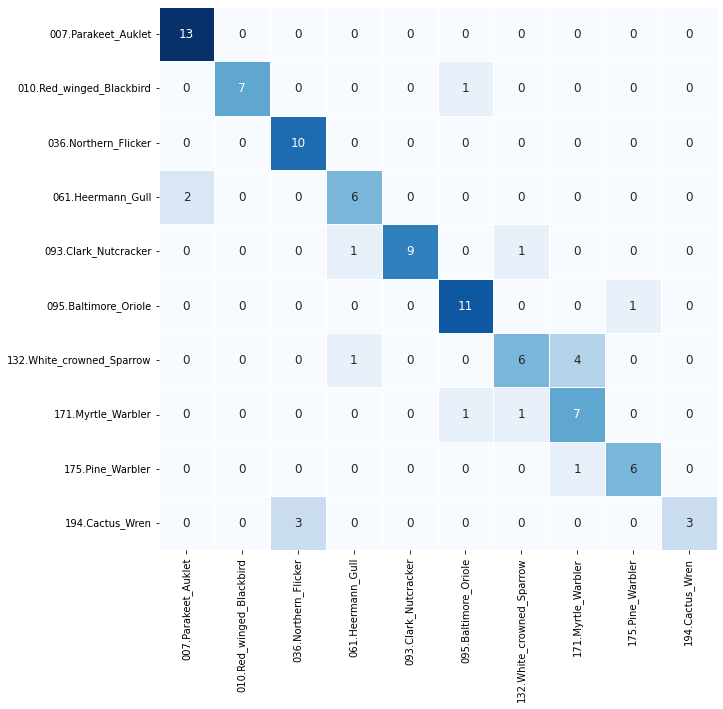

In [15]:
cf_matrix = confusion_matrix(val_y, val_label_predictions)
f, ax = plt.subplots(figsize=(10, 10))
plt.cla()
sns.set(font_scale=1)
sns.heatmap(cf_matrix, 
            fmt="d",
            annot=True, 
            cmap="Blues",
            cbar=False,
            xticklabels=labels, 
            yticklabels=labels,
            linewidths=1, 
            linecolor="white")

### Visualize incorrect predictions
Lastly we can visualize the incorrect predictions. At this point you can apply some domain knowledge to determine whether these mistakes are acceptable (e.g are the predicted and actual species so similar that some degree of misclassification is acceptable)

In [16]:
wrong_predictions = val_data.copy()
wrong_predictions["predicted_class_id"] = val_predicted_class
wrong_predictions = wrong_predictions.query("class_id != predicted_class_id")

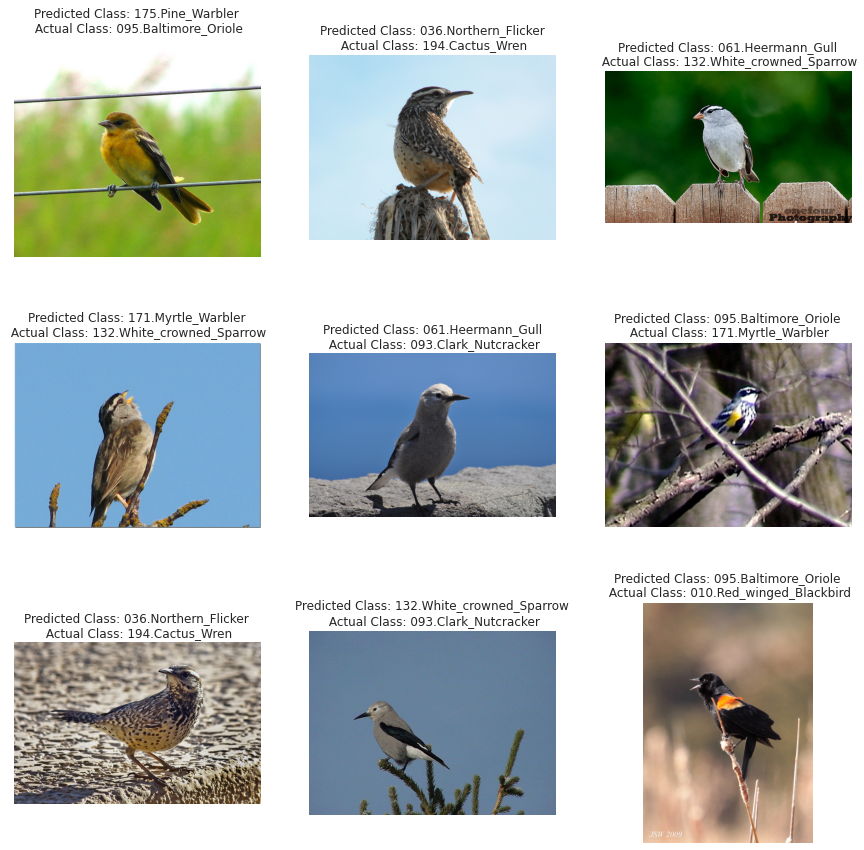

In [17]:
wrong_prediction_sample = wrong_predictions.sample(9).reset_index()

for n, record in wrong_prediction_sample.iterrows():
    title = f'Predicted Class: {record["predicted_class_id"]}\n Actual Class: {record["class_id"]}'
    plt.subplot(3,3, n+1, title=title)
    plt.imshow(plt.imread(record["file_name"]))
    plt.axis("off")

# Model Explainability
In addition to manually reviewing the incorrect predictions, you may want to perform some additional model introspection to analyze how the model came up with these particular predictions.
There are many approaches to analyzing deep learning models. One example is [Saliency Maps](https://raghakot.github.io/keras-vis/visualizations/saliency/). The documentation for Saliency Map visualizer explains the approach:
> Suppose that all the training images of bird class contains a tree with leaves. How do we know whether the CNN is using bird-related pixels, as opposed to some other features such as the tree or leaves in the image? This actually happens more often than you think and you should be especially suspicious if you have a small training set

In this example, we will generate heatmaps which will highlight which pixels have the most impact on the output of the model. Ideally the most salient pixels should overlap with the pixels of the bird as opposed to leaves, clouds, etc.

In [18]:
!pip install -Uqq tf-keras-vis

In [19]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

In [20]:
def model_modifier(model):
    #replace the activation of the final Dense layer
    model.layers[-1].activation = tf.keras.activations.linear
    return model

def loss(output):
    # return the loss value for the true label

    global wrong_predictions
    true_labels = wrong_predictions["label"] 
    output_loss = []
    for n, label in enumerate(true_labels):
        output_loss.append(output[n][label])

    return tuple(output_loss)

In [21]:
saliency = Saliency(model, model_modifier=model_modifier, clone=True) 

In [22]:
misclassified_x = val_x[val_y != val_label_predictions]
saliency_maps = normalize(saliency(loss, misclassified_x))

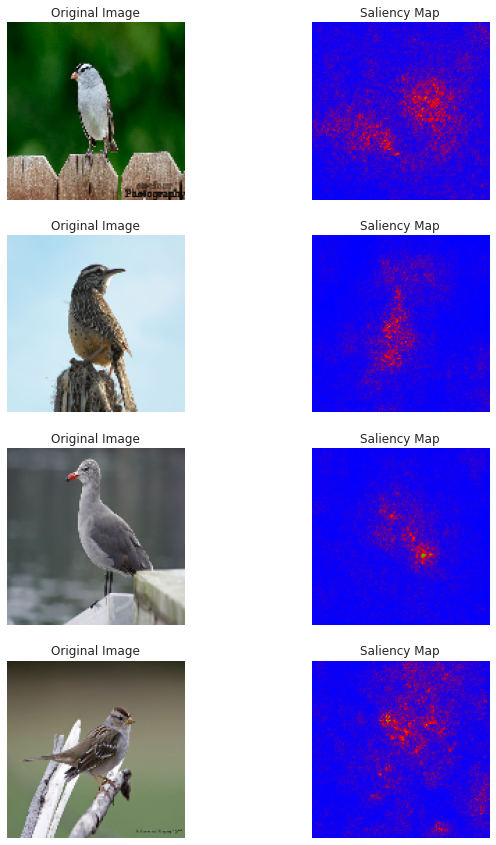

In [23]:
num_plots = 8
plot_idxs = np.random.choice(range(len(misclassified_x)), size=num_plots, replace=False).tolist()
plt.rcParams["figure.figsize"] = (10,15)
for n, (sm, im) in enumerate(zip(saliency_maps[plot_idxs] ,misclassified_x.numpy()[plot_idxs]), 1):
    
    if n%2 == 0:
        title = "Saliency Map"
        plot = sm
        cmap= "brg"
    else:
        title = "Original Image"
        plot = im
        cmap = None
    plt.subplot(4,2, n, title=title)
    plt.imshow(plot, cmap=cmap)
    plt.axis("off")

## Conclusion
In this notebook we went through a complete example of training and evaluating a TensorFlow model. While notebooks are a great facility for interactive experimentation, they do not provide the best facility for getting your notebooks into production. This is where the various SageMaker capabilities can help. The subsequent notebook will outline various features of SageMaker such as Training and Deployment as we'll work on converting this notebook's code into an ML Pipeline